In [1]:
p <- c("vegan","ade4","reshape2","ggplot2","pheatmap","dplyr","vegan", "ape", "igraph",
       "network", "sna", "corrplot", "cowplot", "grid", "GGally")
usePackage <- function(p) {
  if (!is.element(p, installed.packages()[,1]))
    install.packages(p, dep=TRUE, repos="https://cloud.r-project.org/")
  suppressWarnings(suppressMessages(invisible(require(p, character.only=TRUE))))
}
invisible(lapply(p, usePackage))
library("crossRanger")
source("metabo_util.R")
#-------------------------------
setwd('~/MyProjects/SoH_project/multi-omics')

In [2]:
outpath="co-occurrence_network_out/"
dir.create(outpath)

Warning message in dir.create(outpath):
“'co-occurrence_network_out' already exists”

In [3]:
devtools::install_github("briatte/ggnet")
library(ggnet)

Skipping install of 'ggnet' from a github remote, the SHA1 (da9a7cf2) has not changed since last install.
  Use `force = TRUE` to force installation

Attaching package: ‘ggnet’

The following objects are masked from ‘package:GGally’:

    ggnet, ggnet2



## Data input

In [4]:
filename1<-"PlaqueMS275.txt"
prefix1<-"metabolomics"
metadata.filename1<-"PlaqueMS275_Map.txt"
filename2="SoH261.taxa.genus.Abd.OralCore.xls"
prefix2<-"microbiome-genus"
metadata.filename2<-"SoH261_Map.txt"
filename3<-"SoH192_cytokines.txt"
prefix3<-"cytokines"
metadata.filename3<-"SoH192_Map.txt"

outputPath<-"./multi-omics_corr/"
dir.create(outputPath)
f1<-read.table(filename1,header=TRUE,sep="\t",row.names=1, quote=""); f1<-f1[order(rownames(f1)), ]
f2<-read.table(filename2,header=TRUE,sep="\t",row.names=1); f2<-f2[order(rownames(f2)), ]
f3<-read.table(filename3,header=TRUE,sep="\t",row.names=1); f3<-f3[order(rownames(f3)), ]
m1<-read.table(metadata.filename1,header=T,sep="\t",row.names=1); m1<-m1[order(rownames(m1)), ]
m2<-read.table(metadata.filename2,header=T,sep="\t",row.names=1); m2<-m2[order(rownames(m2)), ]
m3<-read.table(metadata.filename3,header=T,sep="\t",row.names=1); m3<-m3[order(rownames(m3)), ]

cat("The order of samples in the metabolome data and metadata are equal:", all.equal(rownames(f1), rownames(m1)), "\n")
cat("The order of samples in the microbiome data and metadata are equal:", all.equal(rownames(f2), rownames(m2)), "\n")
cat("The order of samples in the cytokines data and metadata are equal:", all.equal(rownames(f3), rownames(m3)))


Warning message in dir.create(outputPath):
“'./multi-omics_corr' already exists”

The order of samples in the metabolome data and metadata are equal: TRUE 
The order of samples in the microbiome data and metadata are equal: TRUE 
The order of samples in the cytokines data and metadata are equal: TRUE

## To identify intersected sample IDs between cytokines and microbiomes/metabolomes

In [5]:
Shared_SampleIDs_btw_cytokines_and_metabolome<-intersect(rownames(f1), rownames(f3))
Shared_SampleIDs_btw_cytokines_and_microbiome<-intersect(rownames(f2), rownames(f3))
length(Shared_SampleIDs_btw_cytokines_and_metabolome)
length(Shared_SampleIDs_btw_cytokines_and_microbiome)
Shared_SampleIDs<-intersect(Shared_SampleIDs_btw_cytokines_and_metabolome, Shared_SampleIDs_btw_cytokines_and_microbiome)
cat("# of shared samples across all omics data: ", length(Shared_SampleIDs), "\n")

[1] 192

[1] 186

# of shared samples across all omics data:  186 


In [6]:
f1_s<-f1[Shared_SampleIDs,]; 
m1_s<-m1[Shared_SampleIDs,]; 
cat("The order of samples in the metabolome data and metadata are equal:", all.equal(rownames(f1_s), rownames(m1_s)), "\n")
f2_s<-f2[Shared_SampleIDs,]; 
m2_s<-m2[Shared_SampleIDs,]; 
cat("The order of samples in the microbiome data and metadata are equal:", all.equal(rownames(f2_s), rownames(m2_s)), "\n")
f3_s<-f3[Shared_SampleIDs,]; 
m3_s<-m3[Shared_SampleIDs,]; 
cat("The order of samples in the cytokine data and metadata are equal:", all.equal(rownames(f2_s), rownames(m2_s)), "\n")


The order of samples in the metabolome data and metadata are equal: TRUE 
The order of samples in the microbiome data and metadata are equal: TRUE 
The order of samples in the cytokine data and metadata are equal: TRUE 


## The temporal difference in bleeding

In [7]:
md3<-m2[, c("Host_ID", "Timepoint", "Bleeding")]

In [8]:
f=md3[, "Timepoint"]
comp_group="DAY0"
all_other_groups<-levels(f)[which(levels(f)!=comp_group)]
L<-length(all_other_groups)
#all_groups<-levels(f); L<-length(all_groups)
out<-matrix(NA, ncol=6, nrow=L); 
colnames(out)<-c("mean_diff", "lower_conf.int", "upper_conf.int", "p_value", "IfSig", "cohens_d")
rownames(out)<-paste(comp_group, all_other_groups, sep="_VS_")
for(i in 1:L){
    dataset<-paste(comp_group, all_other_groups[i], sep="_VS_")
    cat("Dataset: ", dataset, "\n")
    comp_md3<-md3[which(f==comp_group | f==all_other_groups[i]), , drop=TRUE]
    comp_md3[, "Timepoint"]<-factor(comp_md3[, "Timepoint"])
    comp_md3[, "Host_ID"]<-factor(comp_md3[, "Host_ID"]) # xtabs(~ Host_ID + Timepoint, data=comp_md3)
    #filter out unpaired hosts
    xtable<-table(comp_md3[,c("Host_ID","Timepoint")]) 
    paired_Host_ID<-names(which(rowSums(xtable)==ncol(xtable)))
    unpaired_Host_ID<-names(which(rowSums(xtable)!=ncol(xtable)))
    cat("unpaired Host IDs: ", unpaired_Host_ID, "\n")
    paired_comp_md3<-subset(comp_md3, Host_ID %in% paired_Host_ID ) #xtabs(~ Host_ID + Timepoint, data=paired_comp_md3)
    # paired t-test
    ttest_out<-t.test(Bleeding ~ Timepoint, data=paired_comp_md3, paired=TRUE)
    out[i,1]<-mean_diff<-abs(ttest_out$estimate)
    out[i,2]<-lower_conf.int<-abs(ttest_out$conf.int)[1]
    out[i,3]<-upper_conf.int<-abs(ttest_out$conf.int)[2]
    out[i,4]<-pval<-ttest_out$p.value
    out[i,5]<-ifsig<-ttest_out$p.value<0.05
    require(lsr)
    out[i,6]<-cohens_d<-cohensD(Bleeding ~ Timepoint, data=paired_comp_md3, method = "paired")
}

out

Dataset:  DAY0_VS_DAY_21 
unpaired Host IDs:   


Loading required package: lsr
Warning message in cohensD(Bleeding ~ Timepoint, data = paired_comp_md3, method = "paired"):
“calculating paired samples Cohen's d using formula input. Results will be incorrect if cases do not appear in the same order for both levels of the grouping factor”

Dataset:  DAY0_VS_DAY01 
unpaired Host IDs:   


Warning message in cohensD(Bleeding ~ Timepoint, data = paired_comp_md3, method = "paired"):
“calculating paired samples Cohen's d using formula input. Results will be incorrect if cases do not appear in the same order for both levels of the grouping factor”

Dataset:  DAY0_VS_DAY03 
unpaired Host IDs:  H3034 


Warning message in cohensD(Bleeding ~ Timepoint, data = paired_comp_md3, method = "paired"):
“calculating paired samples Cohen's d using formula input. Results will be incorrect if cases do not appear in the same order for both levels of the grouping factor”

Dataset:  DAY0_VS_DAY07 
unpaired Host IDs:  H3034 


Warning message in cohensD(Bleeding ~ Timepoint, data = paired_comp_md3, method = "paired"):
“calculating paired samples Cohen's d using formula input. Results will be incorrect if cases do not appear in the same order for both levels of the grouping factor”

Dataset:  DAY0_VS_DAY14 
unpaired Host IDs:  H8003 L9011 


Warning message in cohensD(Bleeding ~ Timepoint, data = paired_comp_md3, method = "paired"):
“calculating paired samples Cohen's d using formula input. Results will be incorrect if cases do not appear in the same order for both levels of the grouping factor”

Dataset:  DAY0_VS_DAY28 
unpaired Host IDs:  H8003 


Warning message in cohensD(Bleeding ~ Timepoint, data = paired_comp_md3, method = "paired"):
“calculating paired samples Cohen's d using formula input. Results will be incorrect if cases do not appear in the same order for both levels of the grouping factor”

,mean_diff,lower_conf.int,upper_conf.int,p_value,IfSig,cohens_d
DAY0_VS_DAY_21,9.0263158,6.9397935,11.1128381,1.465431e-10,1,1.4219240
DAY0_VS_DAY01,0.1315789,0.4292324,0.1660745,3.762104e-01,0,0.1452996
DAY0_VS_DAY03,0.2432432,0.6974560,0.2109695,2.846543e-01,0,0.1785536
DAY0_VS_DAY07,0.9189189,1.4120699,0.4257680,5.713900e-04,1,0.6212759
DAY0_VS_DAY14,3.5000000,4.6622750,2.3377250,5.476767e-07,1,1.0188894
DAY0_VS_DAY28,6.8918919,9.0002870,4.7834968,1.010619e-07,1,1.0898674


### RF modeling across Timepoints (Day 0 VS Day X)

### rf_clf.comps

In [9]:
args(rf_clf.comps)

function (df, f, comp_group, verbose = FALSE, clr_transform = TRUE, 
    rf_imp_values = FALSE, ntree = 500, p.adj.method = "bonferroni", 
    q_cutoff = 0.05) 
NULL

In [10]:
p.adj.method = "BH"

In [11]:
m1_comps<-rf_clf.comps(df=f1, f=m1[, "Timepoint"], comp_group ="DAY0", p.adj.method = p.adj.method)

Loading required package: foreach


In [12]:
m2_comps<-rf_clf.comps(df=f2, f=m2[, "Timepoint"], comp_group ="DAY0", p.adj.method = p.adj.method)
m3_comps<-rf_clf.comps(df=f3, f=m3[, "Timepoint"], comp_group ="DAY0", p.adj.method = p.adj.method)


### plot_clf_res_list

In [13]:
m1_comps.summ<-plot_clf_res_list(m1_comps, p_cutoff=0.05, p.adj.method = p.adj.method, q_cutoff=0.05, outdir=outpath)
m2_comps.summ<-plot_clf_res_list(m2_comps, p_cutoff=0.05, p.adj.method = p.adj.method, q_cutoff=0.05, outdir=outpath)
m3_comps.summ<-plot_clf_res_list(m3_comps, p_cutoff=0.05, p.adj.method = p.adj.method, q_cutoff=0.05, outdir=outpath)


Using Data_sets as id variables
Loading required package: gridExtra

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine

Warning message:
“Removed 6 rows containing missing values (geom_bar).”Using feature, dataset, Enr as id variables
Using Data_sets as id variables
Warning message:
“Removed 6 rows containing missing values (geom_bar).”Warning message:
“Removed 4 rows containing missing values (position_stack).”Warning message:
“Removed 4 rows containing missing values (geom_point).”Using feature, dataset, Enr as id variables
Warning message:
“Removed 4 rows containing non-finite values (stat_boxplot).”Warning message:
“Removed 4 rows containing missing values (geom_point).”Using Data_sets as id variables
Warning message:
“Removed 4 rows containing missing values (geom_bar).”Warning message:
“Removed 1 rows containing missing values (position_stack).”Warning message:
“Removed 1 rows containing missing values (geom_point).”Using feature, d

In [14]:
summary(m3_comps.summ)

                 Length Class      Mode
summ              7     data.frame list
summ_plot         4     gtable     list
feature_res      60     data.frame list
feature_res_plot  9     gg         list

In [15]:
summary(m1_comps.summ$feature_res)

                                      feature               dataset    
 acetoacetate_pos                         :   6   DAY0_VS_DAY-21:1125  
 Acetyl.N.formyl.5.methoxykynurenamine_pos:   6   DAY0_VS_DAY01 :1125  
 Acetylcholine_pos                        :   6   DAY0_VS_DAY03 :1125  
 Acetylphosphate._neg                     :   6   DAY0_VS_DAY07 :1125  
 Adenine_neg                              :   6   DAY0_VS_DAY14 :1125  
 Adenine_pos                              :   6   DAY0_VS_DAY28 :1125  
 (Other)                                  :6714                        
    rf_imps              mean_all            var_all         
 Min.   :-9.430e-04   Min.   :  0.00001   Min.   :   0.0000  
 1st Qu.:-2.153e-05   1st Qu.:  0.00993   1st Qu.:   0.0001  
 Median : 0.000e+00   Median :  0.03742   Median :   0.0008  
 Mean   : 1.481e-04   Mean   :  1.06202   Mean   :   5.1992  
 3rd Qu.: 1.290e-04   3rd Qu.:  0.21726   3rd Qu.:   0.0240  
 Max.   : 1.800e-02   Max.   :157.43299   Max.   :19

In [16]:
summary(m1_comps.summ$feature_res$dataset)
summary(m2_comps.summ$feature_res$dataset)
summary(m3_comps.summ$feature_res$dataset)

DAY0_VS_DAY-21  DAY0_VS_DAY01  DAY0_VS_DAY03  DAY0_VS_DAY07  DAY0_VS_DAY14 
          1125           1125           1125           1125           1125 
 DAY0_VS_DAY28 
          1125

DAY0_VS_DAY_21  DAY0_VS_DAY01  DAY0_VS_DAY03  DAY0_VS_DAY07  DAY0_VS_DAY14 
            44             44             44             44             44 
 DAY0_VS_DAY28 
            44

DAY0_VS_DAY-21  DAY0_VS_DAY03  DAY0_VS_DAY07  DAY0_VS_DAY28 
            27             27             27             27

In [17]:
feature=m1_comps$feature_imps_list[[1]][, "feature"]


In [18]:
tmp<-do.call(rbind, strsplit(as.character(feature), "_"))
summary(tmp)

                            V1          V2     
 Adenosine.diphosphate.ribose:   3   neg :355  
 Citrulline                  :   3   neg.: 14  
 Inosine                     :   3   pos :597  
 L.Acetylcarnitine           :   3   pos.: 25  
 L.Phenylalanine             :   3   TSQ :132  
 L.Tyrosine                  :   3   TSQ.:  2  
 (Other)                     :1107             

In [19]:
#length(m1_comps$feature_imps_list)
m1_Enr<-data.frame(feature=m1_comps$feature_imps_list[[1]][, "feature"],
                   omics="metabolites",
           Day0_VS_Day.21=m1_comps$feature_imps_list[[1]][, "Enr"],
           Day0_VS_Day01=m1_comps$feature_imps_list[[2]][, "Enr"],
           Day0_VS_Day03=m1_comps$feature_imps_list[[3]][, "Enr"],
           Day0_VS_Day07=m1_comps$feature_imps_list[[4]][, "Enr"],
           Day0_VS_Day14=m1_comps$feature_imps_list[[5]][, "Enr"],
           Day0_VS_Day28=m1_comps$feature_imps_list[[6]][, "Enr"])
head(m1_Enr)

feature,omics,Day0_VS_Day.21,Day0_VS_Day01,Day0_VS_Day03,Day0_VS_Day07,Day0_VS_Day14,Day0_VS_Day28
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
Pantothenic.Acid_TSQ,metabolites,DAY0_depleted,Neutral,Neutral,Neutral,Neutral,Neutral
Xanthine_neg,metabolites,DAY0_depleted,Neutral,Neutral,Neutral,DAY0_enriched,DAY0_enriched
X2.keto.valeric.acid_neg,metabolites,DAY0_depleted,Neutral,Neutral,Neutral,Neutral,Neutral
X3.methyl.2.oxobutyrate_neg,metabolites,DAY0_depleted,Neutral,Neutral,Neutral,Neutral,Neutral
Acetylphosphate._neg,metabolites,DAY0_enriched,Neutral,Neutral,Neutral,Neutral,Neutral
Ketoleucine_neg,metabolites,DAY0_depleted,Neutral,Neutral,Neutral,Neutral,Neutral


In [20]:
summary(m1_Enr)

                                      feature             omics     
 acetoacetate_pos                         :   1   metabolites:1125  
 Acetyl.N.formyl.5.methoxykynurenamine_pos:   1                     
 Acetylcholine_pos                        :   1                     
 Acetylphosphate._neg                     :   1                     
 Adenine_neg                              :   1                     
 Adenine_pos                              :   1                     
 (Other)                                  :1119                     
       Day0_VS_Day.21 Day0_VS_Day01        Day0_VS_Day03        Day0_VS_Day07
 Neutral      :925    Neutral:1125   Neutral      :1090   Neutral      :899  
 DAY0_depleted:113                   DAY0_depleted:  18   DAY0_depleted: 95  
 DAY0_enriched: 87                   DAY0_enriched:  17   DAY0_enriched:131  
                                                                             
                                                          

In [21]:
#length(m2_comps$feature_imps_list)
m2_Enr<-data.frame(feature=m2_comps$feature_imps_list[[1]][, "feature"],
                   omics="microbiota",
           Day0_VS_Day.21=m2_comps$feature_imps_list[[1]][, "Enr"],
           Day0_VS_Day01=m2_comps$feature_imps_list[[2]][, "Enr"],
           Day0_VS_Day03=m2_comps$feature_imps_list[[3]][, "Enr"],
           Day0_VS_Day07=m2_comps$feature_imps_list[[4]][, "Enr"],
           Day0_VS_Day14=m2_comps$feature_imps_list[[5]][, "Enr"],
           Day0_VS_Day28=m2_comps$feature_imps_list[[6]][, "Enr"])
head(m2_Enr)

feature,omics,Day0_VS_Day.21,Day0_VS_Day01,Day0_VS_Day03,Day0_VS_Day07,Day0_VS_Day14,Day0_VS_Day28
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
Act_Actinobaculum.,microbiota,Neutral,Neutral,DAY0_enriched,DAY0_enriched,DAY0_enriched,DAY0_enriched
Act_Actinomyces.,microbiota,DAY0_enriched,DAY0_enriched,DAY0_enriched,DAY0_enriched,DAY0_enriched,DAY0_enriched
Aer_Abiotrophia.,microbiota,Neutral,Neutral,DAY0_depleted,DAY0_depleted,Neutral,Neutral
Bac_unclassified_Bacteroidaceae.,microbiota,DAY0_depleted,DAY0_enriched,DAY0_enriched,Neutral,Neutral,DAY0_depleted
Bur_Lautropia.,microbiota,DAY0_enriched,Neutral,Neutral,DAY0_enriched,DAY0_enriched,DAY0_enriched
Cam_Campylobacter.,microbiota,DAY0_depleted,Neutral,Neutral,Neutral,DAY0_depleted,DAY0_depleted


In [22]:
m3_Enr<-data.frame(feature=m3_comps$feature_imps_list[[1]][, "feature"],
                   omics="cytokines",
           Day0_VS_Day.21=m3_comps$feature_imps_list[[1]][, "Enr"],
           Day0_VS_Day01=NA,
           Day0_VS_Day03=m3_comps$feature_imps_list[[2]][, "Enr"],
           Day0_VS_Day07=m3_comps$feature_imps_list[[3]][, "Enr"],
           Day0_VS_Day14=NA,
           Day0_VS_Day28=m3_comps$feature_imps_list[[4]][, "Enr"])
head(m3_Enr)

feature,omics,Day0_VS_Day.21,Day0_VS_Day01,Day0_VS_Day03,Day0_VS_Day07,Day0_VS_Day14,Day0_VS_Day28
<fct>,<fct>,<fct>,<lgl>,<fct>,<fct>,<lgl>,<fct>
MIP.1_beta,cytokines,Neutral,NA,Neutral,Neutral,NA,DAY0_enriched
IL.6,cytokines,Neutral,NA,Neutral,Neutral,NA,Neutral
IFN.gamma,cytokines,Neutral,NA,DAY0_depleted,Neutral,NA,Neutral
IL.1ra,cytokines,Neutral,NA,Neutral,DAY0_depleted,NA,Neutral
IL.5,cytokines,Neutral,NA,Neutral,Neutral,NA,Neutral
GM.CSF,cytokines,Neutral,NA,Neutral,Neutral,NA,Neutral


In [23]:
feature_Enr<-rbind(m1_Enr, m2_Enr, m3_Enr)

In [24]:
#sink(paste(outpath, "All_features_Enr.txt", sep=""))
write.table(feature_Enr, paste(outpath, "All_features_Enr.", p.adj.method, ".txt", sep=""), quote=FALSE, sep="\t", row.names = F)
#sink()

In [25]:
m1_logfc<-acast(m1_comps.summ$feature_res, feature~dataset, value.var=c("mean_logfc"))
m1_logfc<-data.frame(feature=rownames(m1_logfc), omics="metabolites", m1_logfc)

In [26]:
m2_logfc<-acast(m2_comps.summ$feature_res, feature~dataset, value.var=c("mean_logfc"))
m2_logfc<-data.frame(feature=rownames(m2_logfc), omics="microbiota", m2_logfc)

In [27]:
m3_logfc<-acast(m3_comps.summ$feature_res, feature~dataset, value.var=c("mean_logfc"))
m3_logfc<-data.frame(feature=rownames(m3_logfc), omics="microbiota", m3_logfc)
head(m3_logfc)

,feature,omics,DAY0_VS_DAY.21,DAY0_VS_DAY03,DAY0_VS_DAY07,DAY0_VS_DAY28
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
Basic_FGF,Basic_FGF,microbiota,0.07009202,-1.1495146,-1.4707490,-0.464611086
Eotaxin,Eotaxin,microbiota,-0.18786002,-0.5689502,-0.7524275,-0.274387695
G.CSF,G.CSF,microbiota,0.16368514,-0.4926851,-0.6277333,-0.044321381
GM.CSF,GM.CSF,microbiota,-0.05481072,-0.2536215,-0.1257462,-0.348635221
IFN.gamma,IFN.gamma,microbiota,0.12964279,-0.6437000,-0.6034012,0.006858014
IL.1_beta,IL.1_beta,microbiota,-0.05080173,0.7506268,0.2552218,-0.624074728


### Visualize the AUROC in the RF models to reveal the multi-omics changes over time

In [28]:
out

,mean_diff,lower_conf.int,upper_conf.int,p_value,IfSig,cohens_d
DAY0_VS_DAY_21,9.0263158,6.9397935,11.1128381,1.465431e-10,1,1.4219240
DAY0_VS_DAY01,0.1315789,0.4292324,0.1660745,3.762104e-01,0,0.1452996
DAY0_VS_DAY03,0.2432432,0.6974560,0.2109695,2.846543e-01,0,0.1785536
DAY0_VS_DAY07,0.9189189,1.4120699,0.4257680,5.713900e-04,1,0.6212759
DAY0_VS_DAY14,3.5000000,4.6622750,2.3377250,5.476767e-07,1,1.0188894
DAY0_VS_DAY28,6.8918919,9.0002870,4.7834968,1.010619e-07,1,1.0898674


In [29]:
m3_comps$rf_AUC

[1] 0.6530488 0.9993056 0.9993243 0.8927632

In [30]:
probes <- rep(TRUE, length(m3_comps$rf_AUC))
probes <- append(probes, FALSE, after=1)
probes <- append(probes, FALSE, after=4)
cytokines_AUROC=rep(NA, nrow(out))
cytokines_AUROC[probes]<-m3_comps$rf_AUC
probes
cytokines_AUROC 

[1]  TRUE FALSE  TRUE  TRUE FALSE  TRUE

[1] 0.6530488        NA 0.9993056 0.9993243        NA 0.8927632

In [31]:
all_AUROC<-data.frame(out, 
                      metabolome_AUROC=m1_comps$rf_AUC, microboime_AUROC=m2_comps$rf_AUC, cytokines_AUROC)
all_AUROC

,mean_diff,lower_conf.int,upper_conf.int,p_value,IfSig,cohens_d,metabolome_AUROC,microboime_AUROC,cytokines_AUROC
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DAY0_VS_DAY_21,9.0263158,6.9397935,11.1128381,1.465431e-10,1,1.4219240,0.8975000,0.8524931,0.6530488
DAY0_VS_DAY01,0.1315789,0.4292324,0.1660745,3.762104e-01,0,0.1452996,0.5806250,0.7569252,NA
DAY0_VS_DAY03,0.2432432,0.6974560,0.2109695,2.846543e-01,0,0.1785536,0.8307692,0.8719772,0.9993056
DAY0_VS_DAY07,0.9189189,1.4120699,0.4257680,5.713900e-04,1,0.6212759,0.9282051,0.9260313,0.9993243
DAY0_VS_DAY14,3.5000000,4.6622750,2.3377250,5.476767e-07,1,1.0188894,0.9697368,0.9027778,NA
DAY0_VS_DAY28,6.8918919,9.0002870,4.7834968,1.010619e-07,1,1.0898674,0.9782051,0.8911807,0.8927632


In [32]:
DAY0_VS_DAY0 <- c(0, 0, 0, 1, 0, 0, 0.5, 0.5, 0.5)
all_AUROC<-rbind(DAY0_VS_DAY0, all_AUROC)
rownames(all_AUROC)[1]<-"DAY0_VS_DAY0"


In [33]:
all_AUROC<-data.frame(Dataset=rownames(all_AUROC), all_AUROC)
all_AUROC<-all_AUROC[order(rownames(all_AUROC)),]

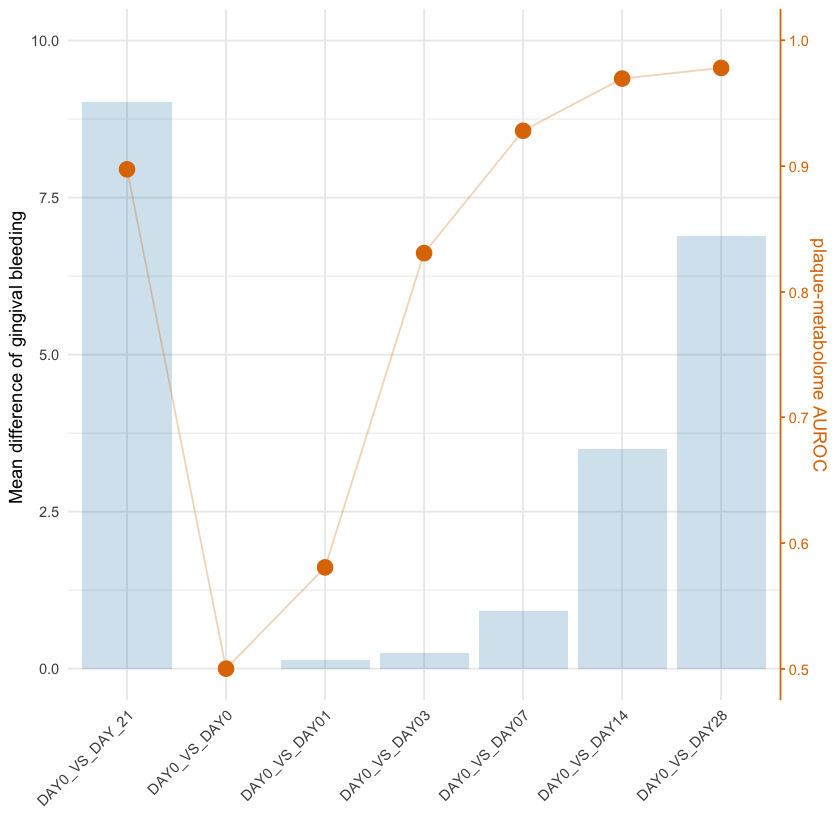

In [34]:
ylim.prim <- c(0, 10)   # in this example, bleeding
ylim.sec <- c(0.5, 1)  # in this example, AUROC
b <- diff(ylim.prim)/diff(ylim.sec)
a <- b*(ylim.prim[1] - ylim.sec[1])
color.sec="#DF7800"
p_comb_AUROC_metabolome<- ggplot(all_AUROC, aes(x=Dataset, y=mean_diff, group = 1)) + 
    xlab("") + ylab("Mean difference of gingival bleeding ")+ 
    geom_bar(aes(x=Dataset, y=mean_diff, fill=IfSig), stat = "identity", alpha=0.2, fill="#0072B2")+ #geom_bar(stat = "identity", alpha=0.5, width=0.01) +
    #geom_errorbar(aes(ymin=mean_diff-lower_conf.int, ymax=mean_diff+upper_conf.int), width=.1, alpha=0.3) +    
    #geom_hline(yintercept=0.5, linetype="dashed")+
    geom_point(aes(x=Dataset, y= a + metabolome_AUROC*b), size=4, color = color.sec)+ #shape="diamond", shape=16, 
    geom_path(aes(x=Dataset, y=a + metabolome_AUROC*b), alpha=0.3, color = color.sec)+ #c("#D55E00", "#0072B2")
    scale_y_continuous(sec.axis = sec_axis(~(. - a)/b, name = "plaque-metabolome AUROC"), limits=ylim.prim) +
    theme_bw()+ theme(legend.position='none')+theme_minimal()+
    theme(axis.text.x = element_text(angle = 45, hjust = 1))+
    theme(axis.line.y.right = element_line(color = color.sec),  
        axis.ticks.y.right = element_line(color = color.sec),
        axis.text.y.right = element_text(color = color.sec), 
        axis.title.y.right = element_text(color = color.sec)
        )

p_comb_AUROC_metabolome

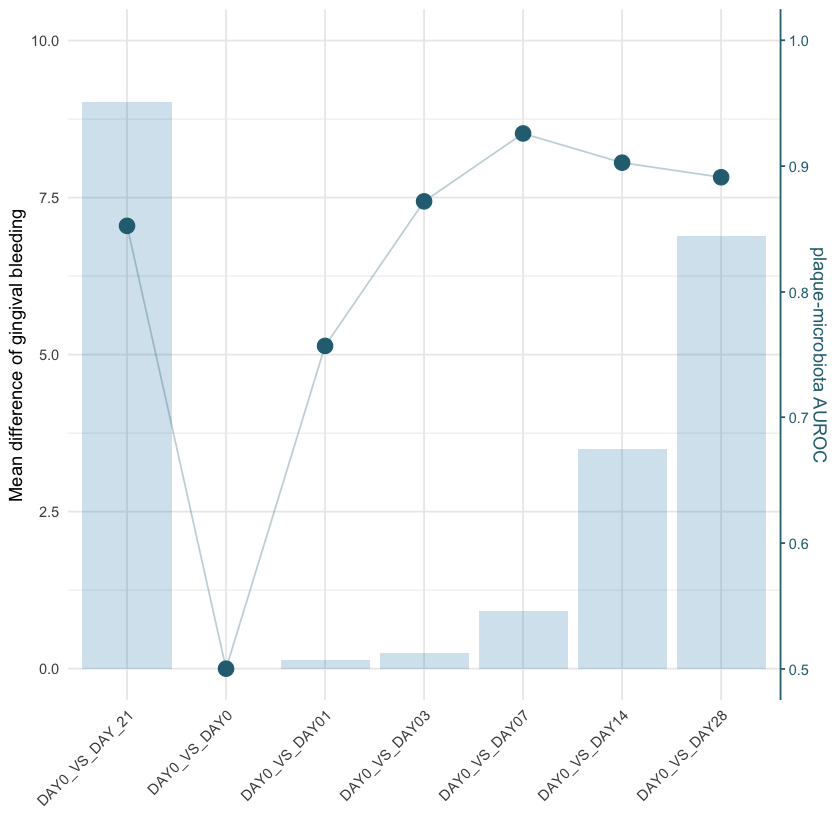

In [35]:
color.sec="#2A6E81"
p_comb_AUROC_16S<- ggplot(all_AUROC, aes(x=Dataset, y=mean_diff, group = 1)) + 
    xlab("") + ylab("Mean difference of gingival bleeding")+ 
    geom_bar(aes(x=Dataset, y=mean_diff, fill=IfSig), stat = "identity", alpha=0.2, fill="#0072B2")+ #geom_bar(stat = "identity", alpha=0.5, width=0.01) +
    #geom_errorbar(aes(ymin=mean_diff-lower_conf.int, ymax=mean_diff+upper_conf.int), width=.1, alpha=0.3) +    
    #geom_hline(yintercept=0.5, linetype="dashed")+
    geom_point(aes(x=Dataset, y= a + microboime_AUROC*b), size=4, color = color.sec)+ #shape="diamond", shape=17, 
    geom_path(aes(x=Dataset, y=a + microboime_AUROC*b), alpha=0.3, color = color.sec)+ #c(color.sec, "#0072B2")
    #coord_flip()+ # if want to filp coordinate
    scale_y_continuous(sec.axis = sec_axis(~(. - a)/b, name = "plaque-microbiota AUROC"), limits=ylim.prim) +
    theme_bw()+ theme(legend.position='none')+ theme_minimal()+
    theme(axis.text.x = element_text(angle = 45, hjust = 1))+
    theme(axis.line.y.right = element_line(color = color.sec),  
        axis.ticks.y.right = element_line(color = color.sec),
        axis.text.y.right = element_text(color = color.sec), 
        axis.title.y.right = element_text(color = color.sec)
        )
p_comb_AUROC_16S

Warning message:
“Removed 2 rows containing missing values (geom_point).”

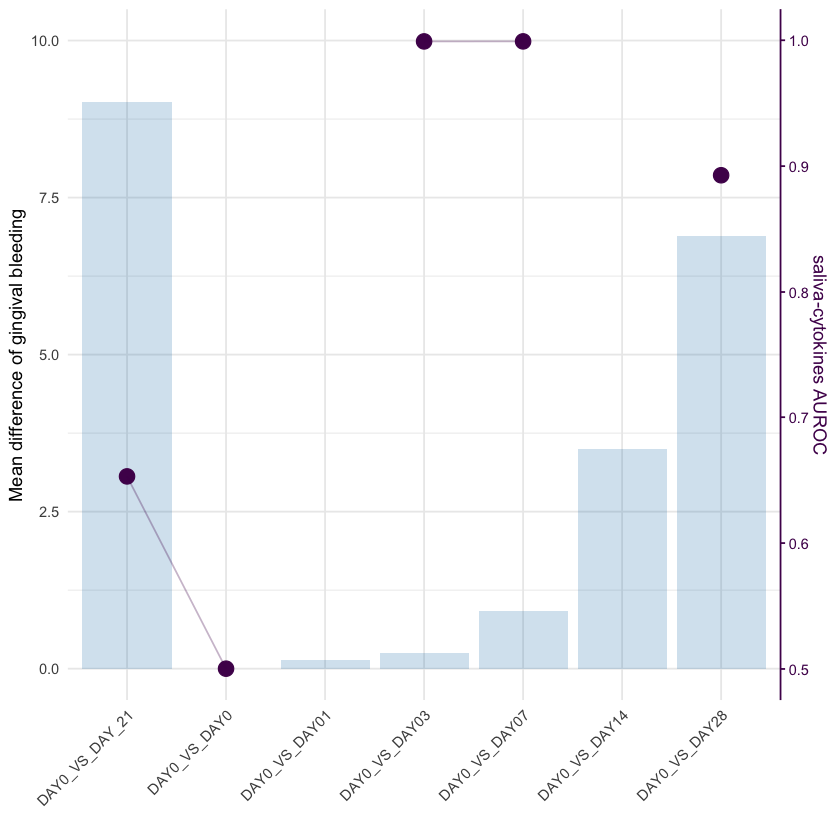

In [36]:
color.sec="#50105A"##"#45164B"
p_comb_AUROC_cytokines<- ggplot(all_AUROC, aes(x=Dataset, y=mean_diff, group = 1)) + 
    xlab("") + ylab("Mean difference of gingival bleeding")+ 
    geom_bar(aes(x=Dataset, y=mean_diff, fill=IfSig), stat = "identity", alpha=0.2, fill="#0072B2")+ #geom_bar(stat = "identity", alpha=0.5, width=0.01) +
    #geom_errorbar(aes(ymin=mean_diff-lower_conf.int, ymax=mean_diff+upper_conf.int), width=.1, alpha=0.3) +    
    #geom_hline(yintercept=0.5, linetype="dashed")+
    geom_point(aes(x=Dataset, y= a + cytokines_AUROC*b), size=4, color = color.sec)+  #shape=18, 
    geom_path(aes(x=Dataset, y=a + cytokines_AUROC*b), alpha=0.3, color = color.sec)+ #c(color.sec, "#0072B2")
    #coord_flip()+ # if want to filp coordinate
    scale_y_continuous(sec.axis = sec_axis(~(. - a)/b, name = "saliva-cytokines AUROC"), limits=ylim.prim) +
    theme_bw()+ theme(legend.position='none')+ theme_minimal()+
    theme(axis.text.x = element_text(angle = 45, hjust = 1))+
    theme(axis.line.y.right = element_line(color = color.sec),  
        axis.ticks.y.right = element_line(color = color.sec),
        axis.text.y.right = element_text(color = color.sec), 
        axis.title.y.right = element_text(color = color.sec)
        )
p_comb_AUROC_cytokines

In [37]:
ggsave(filename=paste(outpath, "/Bleeding.AUROC_microbiota.ggplot.pdf",sep=""),p_comb_AUROC_16S, width=5, height=5)
ggsave(filename=paste(outpath, "/Bleeding.AUROC_metabolome.ggplot.pdf",sep=""),p_comb_AUROC_metabolome, width=5, height=5)
ggsave(filename=paste(outpath, "/Bleeding.AUROC_cytokines.ggplot.pdf",sep=""),p_comb_AUROC_cytokines, width=5, height=5)

Warning message:
“Removed 2 rows containing missing values (geom_point).”

## The correlation of each pair of measurements
-- edge table


### combine all samples with paired omics data

In [38]:
df<-cbind(f1_s, f2_s, f3_s)
dim(df)

[1]  186 1196

In [39]:
ncol(f1_s)
ncol(f2_s)
ncol(f3_s)

[1] 1125

[1] 44

[1] 27

### feature metadata

In [40]:
mtypes<-c(rep("metabolite", ncol(f1_s)), rep("microbiota", ncol(f2_s)), rep("cytokine", ncol(f3_s)))

In [41]:
group<-data.frame(features=colnames(df), measurement_types=mtypes)

### correlation matrix for the co-occurrence network

In [42]:
Corr_mat<-cor(df, method = "spearman")

In [43]:
vectorize_dm<-function(dm, group=NULL, duplicate=TRUE)
{
        if(ncol(dm)!=nrow(dm) & any(is.na(dm))==TRUE)
        stop('The distance matrix is not squared')
        dm<-data.matrix(dm)
        require("reshape2")
    if(!is.null(group)){
        if( length(unique(group))==1)
        stop('At least two levels for a given sample category in your metadata file are required.')
        if( length(group)!=nrow(dm))
        stop('The number of rows in metadata and distance matrix are not equal')
        if(is.factor(group) & nlevels(group)>length(group)*0.9)
        stop('The number of levels in a certain category can not exceed 90% of total number of samples')
        
        colnames(dm)<-rownames(dm)<-paste(rownames(dm), group, sep="____")
        if(duplicate){ 
        melt_dm<-subset(melt(dm), value!=0 & value!=1) 
        }else{ 
        dm[lower.tri(dm)]<-NA
        melt_dm<-subset(melt(dm), ! is.na(value) & value!=0 & value!=1) 
        }
        
        Row_Info<-data.frame(do.call(rbind,strsplit(as.character(melt_dm[,1]),"____",fixed=TRUE)))
        Col_Info<-data.frame(do.call(rbind,strsplit(as.character(melt_dm[,2]),"____",fixed=TRUE)))
        VS<-paste(Row_Info[,2],"_VS._",Col_Info[,2],sep="")
        dm_value<-data.frame(VS,Row_Info,Col_Info,d=melt_dm$value)
        
        colnames(dm_value)<-c("GroupPair","Sample_1","Group_1","Sample_2","Group_2","value")
        if(is.factor(group)){
        DistType<-as.factor(dm_value$Group_1==dm_value$Group_2)
        DistType<-factor(DistType,levels=levels(DistType),labels=c("AllBetween","AllWithin"))
        dm_value<-data.frame(DistType,dm_value)}
    }else{
        if (duplicate) { 
        dm_value<-subset(melt(dm), value!=0 & value!=1)  
        }else{ 
        dm[lower.tri(dm)] <- NA
        dm_value <- subset(melt(dm), ! is.na(value) & value!=0 & value!=1)  }
        colnames(dm_value)<-c("Sample_1","Sample_2","value")
        }
   
dm_value

}

In [44]:
Trim_v_corr_mat<-function(v_Corr_mat, Pos_Edge=TRUE, Neg_Edge=TRUE, Threshold=0.6){
                 if (Pos_Edge & Neg_Edge){
                               v_Corr_mat <- subset(v_Corr_mat, value > Threshold | value < (-Threshold))
                           }else if (Pos_Edge){
                               v_Corr_mat <- subset(v_Corr_mat, value > Threshold & value < 1)
                           }else if (Neg_Edge){
                               v_Corr_mat <- subset(v_Corr_mat, value > -1 & value < (-Threshold))
                           }else stop('Please check the pos/neg edges parameters')
                  v_Corr_mat 
                  }  

In [45]:
dim(Corr_mat)
dim(group)

[1] 1196 1196

[1] 1196    2

In [46]:
v_Corr_mat<-vectorize_dm(Corr_mat, group = group$measurement_types, duplicate=FALSE)
dim(v_Corr_mat)

[1] 714607      7

In [47]:
v_Corr_mat0.6<-Trim_v_corr_mat(v_Corr_mat, Threshold=0.6)
dim(v_Corr_mat0.6)
#sink(paste(outpath, "v_Corr_mat_0.6.txt", sep="")); cat("\t"); 
#write.table(v_Corr_mat0.6, sep="\t", quote=FALSE, row.names = FALSE); sink(NULL)
write.table(v_Corr_mat0.6, paste(outpath, "v_Corr_mat_0.6.txt", sep=""), sep="\t", quote=FALSE, row.names = FALSE)

[1] 27942     7

In [48]:
dim(v_Corr_mat0.6[which(v_Corr_mat0.6$GroupPair=="metabolite_VS._microbiota"), ])
dim(v_Corr_mat0.6[which(v_Corr_mat0.6$GroupPair=="metabolite_VS._metabolite"), ])

[1] 51  7

[1] 27726     7

In [49]:
27726/27942

[1] 0.9922697

In [50]:
v_Corr_mat0.6[which(v_Corr_mat0.6$GroupPair=="metabolite_VS._microbiota"), ]

,DistType,GroupPair,Sample_1,Group_1,Sample_2,Group_2,value
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>
636779,AllBetween,metabolite_VS._microbiota,X.2.3.Diaminopropionic.acid_TSQ.,metabolite,Bur_Lautropia.,microbiota,0.6282308
636781,AllBetween,metabolite_VS._microbiota,X3.Hydroxycapric.acid_neg,metabolite,Bur_Lautropia.,microbiota,0.6282084
636845,AllBetween,metabolite_VS._microbiota,X.2.3.dihydroxybenzoate_neg.,metabolite,Bur_Lautropia.,microbiota,0.6908802
644696,AllBetween,metabolite_VS._microbiota,X5..methylthioadenosine_neg,metabolite,Eub_Eubacterium.,microbiota,-0.6323236
652657,AllBetween,metabolite_VS._microbiota,Phenylacetic.acid_neg,metabolite,Mic_Rothia.,microbiota,0.6221681
652658,AllBetween,metabolite_VS._microbiota,betaine_TSQ,metabolite,Mic_Rothia.,microbiota,0.7024011
652683,AllBetween,metabolite_VS._microbiota,Benzenebutanoic.acid_neg,metabolite,Mic_Rothia.,microbiota,0.6213466
652707,AllBetween,metabolite_VS._microbiota,Leu.Gly_neg,metabolite,Mic_Rothia.,microbiota,0.6770934
652732,AllBetween,metabolite_VS._microbiota,Oxalureate_neg,metabolite,Mic_Rothia.,microbiota,0.6362090


In [51]:
subset(v_Corr_mat0.6, Sample_1=="Mic_Rothia." | Sample_2=="Mic_Rothia.")

,DistType,GroupPair,Sample_1,Group_1,Sample_2,Group_2,value
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>
652657,AllBetween,metabolite_VS._microbiota,Phenylacetic.acid_neg,metabolite,Mic_Rothia.,microbiota,0.6221681
652658,AllBetween,metabolite_VS._microbiota,betaine_TSQ,metabolite,Mic_Rothia.,microbiota,0.7024011
652683,AllBetween,metabolite_VS._microbiota,Benzenebutanoic.acid_neg,metabolite,Mic_Rothia.,microbiota,0.6213466
652707,AllBetween,metabolite_VS._microbiota,Leu.Gly_neg,metabolite,Mic_Rothia.,microbiota,0.6770934
652732,AllBetween,metabolite_VS._microbiota,Oxalureate_neg,metabolite,Mic_Rothia.,microbiota,0.6362090
652738,AllBetween,metabolite_VS._microbiota,Tyrosol_neg,metabolite,Mic_Rothia.,microbiota,0.6004765
652747,AllBetween,metabolite_VS._microbiota,Azelaic.acid_neg,metabolite,Mic_Rothia.,microbiota,0.6062978
652813,AllBetween,metabolite_VS._microbiota,X3.Methylphenylacetic.acid_neg,metabolite,Mic_Rothia.,microbiota,-0.6557047
652816,AllBetween,metabolite_VS._microbiota,X4.Coumaryl.alcohol_neg,metabolite,Mic_Rothia.,microbiota,-0.6477714


In [52]:
v_Corr_mat0.8<-Trim_v_corr_mat(v_Corr_mat, Threshold=0.8)
dim(v_Corr_mat0.8)
#sink(paste(outpath, "v_Corr_mat_0.8.txt", sep="")); cat("\t"); 
#write.table(v_Corr_mat0.8, sep="\t", quote=FALSE, row.names = FALSE); sink(NULL)
write.table(v_Corr_mat0.8, paste(outpath, "v_Corr_mat_0.8.txt", sep=""), sep="\t", quote=FALSE, row.names = FALSE)

[1] 8556    7

In [53]:
#head(subset(v_Corr_mat0.6, GroupPair=="microbiota_VS._metabolite" | GroupPair=="metabolite_VS._microbiota"))

In [54]:
Threshold=0.8
g<-Plot_network_graph(Corr_mat, Pos_Edge=TRUE, Neg_Edge=TRUE, 
                   Threshold=Threshold, Edge_width="Corr", node_size="degree", 
                   node_color="", 
                   layout="layout.fruchterman.reingold", 
                   outdir=paste(outpath,"/network_", Threshold=Threshold,"_out.pdf", sep=""),
                   width=9, height=10)

Warning message in centralization.closeness(g):
“At centrality.c:2784 :closeness centrality is not well-defined for disconnected graphs”

## Co-occurence network at Day 0, 3, and 7

In [55]:
idx<-m2_s$Timepoint %in% c("DAY0", "DAY03", "DAY07")
df_SoH<-df[idx, ]
md_SoH<-m2_s[idx,]
dim(df_SoH)
head(md_SoH)

[1]  111 1196

,Host_ID,PNO_identity,Plaque,Timepoint,Day,Visit,Plaque_weight,Bleeding,Mazza,Halimeter,Group_short,Group,Age,Gender,Smoking,Delta_R30,Delta_R70,Delta_R120,sps
,<fct>,<int>,<fct>,<fct>,<int>,<fct>,<dbl>,<int>,<dbl>,<int>,<fct>,<fct>,<int>,<fct>,<fct>,<int>,<int>,<int>,<int>
H3003_0,H3003,3003,PlaqueA,DAY0,0,T4,0.0035,1,1.0179,171,H,High_bleeder,38,F,N,35,1,0,0
H3003_3,H3003,3003,PlaqueA,DAY03,3,T6,0.0048,1,1.0357,87,H,High_bleeder,38,F,N,39,4,0,0
H3003_7,H3003,3003,PlaqueA,DAY07,7,T7,0.0092,0,1.0000,243,H,High_bleeder,38,F,N,31,2,0,0
H3007_0,H3007,3007,PlaqueB,DAY0,0,T4,0.0050,1,1.0179,98,H,High_bleeder,37,F,N,105,12,1,1
H3007_3,H3007,3007,PlaqueB,DAY03,3,T6,0.0070,5,1.1071,174,H,High_bleeder,37,F,N,268,47,4,2
H3007_7,H3007,3007,PlaqueB,DAY07,7,T7,0.0125,4,1.1071,251,H,High_bleeder,37,F,N,758,193,83,5


In [56]:
Corr_mat_SoH<-cor(df_SoH, method = "spearman")
v_Corr_mat_SoH<-vectorize_dm(Corr_mat_SoH, group = group$measurement_types, duplicate=FALSE)
dim(v_Corr_mat_SoH)

[1] 714346      7

In [57]:
v_Corr_mat_SoH0.6<-Trim_v_corr_mat(v_Corr_mat_SoH, Threshold=0.6)
dim(v_Corr_mat_SoH0.6)
str(v_Corr_mat_SoH0.6)

[1] 27820     7

'data.frame':	27820 obs. of  7 variables:
 $ DistType : Factor w/ 2 levels "AllBetween","AllWithin": 2 2 2 2 2 2 2 2 2 2 ...
 $ GroupPair: Factor w/ 6 levels "cytokine_VS._cytokine",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ Sample_1 : Factor w/ 1195 levels "acetoacetate_pos",..: 1101 1101 1128 1101 1128 4 1101 1128 462 1101 ...
 $ Group_1  : Factor w/ 3 levels "cytokine","metabolite",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ Sample_2 : Factor w/ 1195 levels "acetoacetate_pos",..: 1128 4 4 463 463 463 599 599 599 756 ...
 $ Group_2  : Factor w/ 3 levels "cytokine","metabolite",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ value    : num  0.998 -0.629 -0.623 0.94 0.937 ...


In [58]:
#sink(paste(outpath, "v_Corr_mat_SoH.0.6.txt", sep="")); 
write.table(v_Corr_mat_SoH0.6, paste(outpath, "v_Corr_mat_SoH.0.6.txt", sep=""), sep="\t", quote=FALSE, row.names=F)
#sink(NULL)

In [59]:
v_Corr_mat_SoH0.5<-Trim_v_corr_mat(v_Corr_mat_SoH, Threshold=0.5)
dim(v_Corr_mat_SoH0.5)
str(v_Corr_mat_SoH0.5)
write.table(v_Corr_mat_SoH0.5, paste(outpath, "v_Corr_mat_SoH.0.5.txt", sep=""), sep="\t", quote=FALSE, row.names=F)

[1] 50246     7

'data.frame':	50246 obs. of  7 variables:
 $ DistType : Factor w/ 2 levels "AllBetween","AllWithin": 2 2 2 2 2 2 2 2 2 2 ...
 $ GroupPair: Factor w/ 6 levels "cytokine_VS._cytokine",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ Sample_1 : Factor w/ 1195 levels "acetoacetate_pos",..: 1101 1101 1128 1101 1128 4 1101 1128 4 462 ...
 $ Group_1  : Factor w/ 3 levels "cytokine","metabolite",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ Sample_2 : Factor w/ 1195 levels "acetoacetate_pos",..: 1128 4 4 463 463 463 98 98 98 98 ...
 $ Group_2  : Factor w/ 3 levels "cytokine","metabolite",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ value    : num  0.998 -0.629 -0.623 0.94 0.937 ...


In [60]:
subset(v_Corr_mat_SoH0.5, GroupPair=="cytokine_VS._microbiota")

DistType,GroupPair,Sample_1,Group_1,Sample_2,Group_2,value
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>


In [61]:
head(subset(v_Corr_mat_SoH0.5, GroupPair=="microbiota_VS._microbiota"))

,DistType,GroupPair,Sample_1,Group_1,Sample_2,Group_2,value
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>
634254,AllWithin,microbiota_VS._microbiota,Act_Actinobaculum.,microbiota,Act_Actinomyces.,microbiota,0.5731648
639893,AllWithin,microbiota_VS._microbiota,Act_Actinobaculum.,microbiota,Car_Cardiobacterium.,microbiota,0.5801588
639894,AllWithin,microbiota_VS._microbiota,Act_Actinomyces.,microbiota,Car_Cardiobacterium.,microbiota,0.6141541
639895,AllWithin,microbiota_VS._microbiota,Aer_Abiotrophia.,microbiota,Car_Cardiobacterium.,microbiota,-0.5087543
642159,AllWithin,microbiota_VS._microbiota,Bac_unclassified_Bacteroidaceae.,microbiota,Clo_Parvimonas.,microbiota,0.5614666
644429,AllWithin,microbiota_VS._microbiota,Car_Cardiobacterium.,microbiota,Cor_Corynebacterium.,microbiota,0.5238241


In [62]:
sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS  10.14.6

Matrix products: default
BLAS/LAPACK: /Users/huangshi/anaconda3/envs/r-env/lib/R/lib/libRblas.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] gridExtra_2.3        foreach_1.4.7        lsr_0.5             
 [4] ggnet_0.1.0          optparse_1.6.4       plyr_1.8.5          
 [7] combinat_0.0-8       pROC_1.16.1          reshape_0.8.8       
[10] crossRanger_0.1.0    GGally_1.4.0         cowplot_1.0.0       
[13] corrplot_0.84        sna_2.5              statnet.common_4.3.0
[16] network_1.16.0       igraph_1.2.2         ape_5.3             
[19] dplyr_0.8.3          pheatmap_1.0.12      ggplot2_3.3.0       
[22] reshape2_1.4.3       ade4_1.7-13          vegan_2.5-6         
[25] lattice_0.20-38      permute_0.9